In [1]:
!pip3 install deap
!pip3 install json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [3]:
import json
FORCE_CONTIGUOUS_FORWARD = True
DIFFERENT_MAXIMA = True
print('DIFFERENT_MAXIMA =', DIFFERENT_MAXIMA)

ALSO_FORCE_ON_CPUS = True  #
with open('bert24_training.json', 'r') as file:
    graph = json.load(file)

maxFpgas = graph['maxFPGAs']
maxCpus = graph['maxCPUs']
maxSizePerFpga = graph['maxSizePerFPGA']
nodes = {}
arbitraryNumber = -2000000000
for node in graph['nodes']:
    if 'size' not in node:
        node['size'] = 0.0
    if 'colorClass' not in node:
        node['colorClass'] = arbitraryNumber
        arbitraryNumber += 1
    if 'containedNodes' in node:
        raise "input should not have containedNodes"
    nodes[node['id']] = node

outgoingConnectionCost = {}
for edge in graph['edges']:
    u = edge['sourceId']
    v = edge['destId']
    if u in outgoingConnectionCost:
        if abs(outgoingConnectionCost[u] - edge['cost']) > 1e-6:
            raise ("node " + str(u) + " has two different outgoing connection costs")
    else:
        outgoingConnectionCost[u] = edge['cost']
# set 0 where a node had no outgoing edges
for node_id, node in nodes.items():
    if node_id not in outgoingConnectionCost:
        outgoingConnectionCost[node_id] = 0.0

DIFFERENT_MAXIMA = True


Best EDP: 883945.7175736855
Best EDP: 576609.7781990273
Best EDP: 374433.1727036104
Best EDP: 301841.1228919154
Best EDP: 300148.77974551416
Best EDP: 268961.88790426834
Best EDP: 268961.88790426834


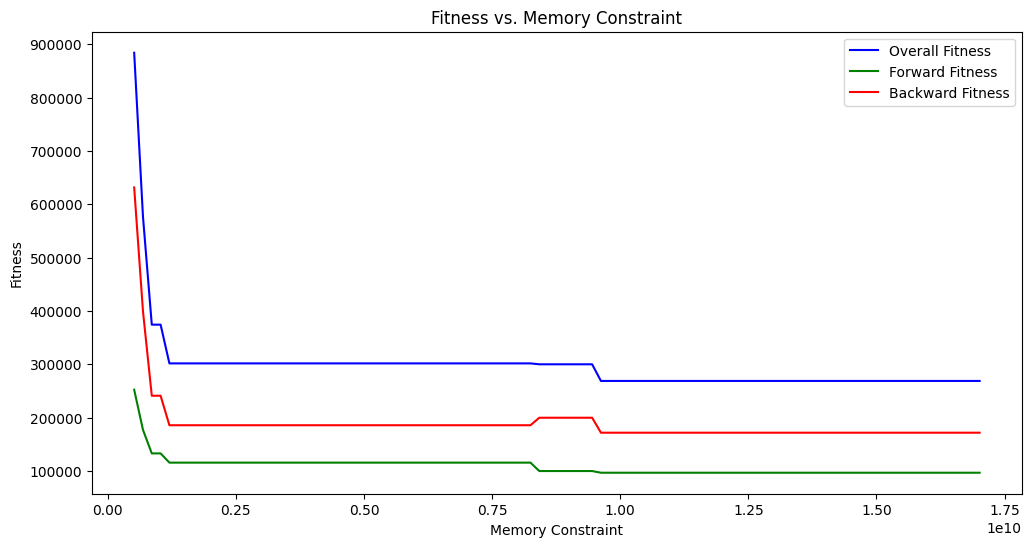

In [4]:
#RUN FOR GPIPE RESULTS
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Number of layers in your neural network and number of devices
NUM_LAYERS = len(graph['nodes'])
NUM_DEVICES = graph['maxFPGAs']
b = 20
def evaluate_pipeline_configuration(individual, max_memory):
    # Initialize variables for loads and memory usage
    device_load_fw = [0] * (NUM_DEVICES + 1)  # Forward load for each device, +1 to account for the CPU
    device_load_bw = [0] * (NUM_DEVICES + 1)  # Backward load for each device, +1 to account for the CPU
    device_memory_usage = [0] * (NUM_DEVICES + 1)  # Memory usage for each device, +1 to account for the CPU
    communication_time = [0] * (NUM_DEVICES + 1)  # Communication time for each device, +1 to account for the CPU
    energy_costs_forward = [0] * (NUM_DEVICES + 1)  # Energy costs for each device, +1 to account for the CPU
    energy_costs_backward = [0] * (NUM_DEVICES + 1)
    communication_time_fw = [0] * (NUM_DEVICES + 1)  # Forward communication time for each device
    communication_time_bw = [0] * (NUM_DEVICES + 1)  # Backward communication time for each device


    # Process each node in the graph
    for node in graph['nodes']:
        size = node['size']
        weight_memory_cost = node['weightMemory']
        activation_memory_cost = node['activationMemory']  * (NUM_DEVICES + 1) # Adjust as per your requirement
        computation_time = node['fpgaLatency'] if node['supportedOnFpga'] else node['cpuLatency']
        node_id = node['id']
        assigned_device = individual[node_id]

        # Update memory usage
        device_memory_usage[assigned_device] += weight_memory_cost + activation_memory_cost

        # Update load based on whether the node is forward or backward
        if not node['isBackwardNode']:
            device_load_fw[assigned_device] += computation_time
            energy_costs_forward[assigned_device] += node['energy']
        else:
            device_load_bw[assigned_device] += computation_time
            energy_costs_backward[assigned_device] += node['energy']

    # Calculate communication time from edges
    for edge in graph['edges']:
      u, v = edge['sourceId'], edge['destId']
      cost = edge['cost']  # Adjust cost for bandwidth

      # Determine devices for the source and destination nodes
      u_device, v_device = individual[u], individual[v]

      # Determine if the nodes are forward or backward
      is_u_forward = not graph['nodes'][u]['isBackwardNode']
      is_v_forward = not graph['nodes'][v]['isBackwardNode']

      # Update load with communication cost if there's a transition between devices
      if u_device != v_device:
          if is_u_forward and is_v_forward:
              # Both nodes are forward
              communication_time_fw[u_device] += cost
              communication_time_fw[v_device] += cost
          elif not is_u_forward and not is_v_forward:
              # Both nodes are backward
              communication_time_bw[u_device] += cost
              communication_time_bw[v_device] += cost
          else:
              # One node is forward and the other is backward, split the cost
              communication_time_fw[u_device] += cost / 2
              communication_time_bw[v_device] += cost / 2
              communication_time_fw[v_device] += cost / 2
              communication_time_bw[u_device] += cost / 2

    max_load_fw = max([device_load_fw[i] + communication_time_fw[i] for i in range(NUM_DEVICES + 1)]) * (NUM_DEVICES + 1)
    max_load_bw = max([device_load_bw[i] + communication_time_bw[i] for i in range(NUM_DEVICES + 1)])* (NUM_DEVICES + 1)
    fitness_fw = max_load_fw * max(energy_costs_forward)  # Fitness for forward nodes
    fitness_bw = max_load_bw * max(energy_costs_backward)  # Fitness for backward nodes

    # Check memory constraints
    for i in range(NUM_DEVICES + 1):
        if device_memory_usage[i] > max_memory:
            fitness_fw = float('inf')  # Invalidate if memory exceeded
            fitness_bw = float('inf')
            fitness = float('inf')
            return fitness, fitness_fw, fitness_bw
    fitness = fitness_fw+fitness_bw

    return fitness, fitness_fw, fitness_bw


# Create classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Initialize
toolbox = base.Toolbox()
toolbox.register("attr_device", random.randint, 0, NUM_DEVICES-1)

def next_device(current_device):
    return random.randint(-1, NUM_DEVICES - 1)


# Initialize individuals with contiguous device assignment
def create_individual():
    individual = [-1] * len(graph['nodes'])  # Initialize individual with -1 (CPU) for all nodes
    color_class_location = {}  # Track the assigned device for each color class

    for node in graph['nodes']:
        node_id = node['id']
        color_class = node['colorClass']

        # Check if the color class has already been assigned a device
        if color_class in color_class_location:
            assigned_device = color_class_location[color_class]
        else:
            assigned_device = next_device(None)  # Randomly select a new device
            color_class_location[color_class] = assigned_device  # Assign this device to the color class

        individual[node_id] = assigned_device

    return individual



toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Mutation operator
def non_contiguous_mutation(individual):
    point = random.randint(0, len(individual) - 1)
    color_class = graph['nodes'][point]['colorClass']

    # Find all nodes with the same color class
    same_class_nodes = [node_id for node_id, node in enumerate(graph['nodes']) if node['colorClass'] == color_class]

    # Mutate all nodes with the same color class to a new device
    new_device = next_device(None)
    for node_id in same_class_nodes:
        individual[node_id] = new_device

    return individual,

toolbox.register("mutate", non_contiguous_mutation)

# Crossover operator
def contiguous_crossover(ind1, ind2):
    # Choose a crossover point that is not on the ends
    point = random.randint(1, len(ind1) - 2)
    # Swap the partitions at the crossover point
    ind1[point:], ind2[point:] = ind2[point:], ind1[point:]
    return ind1, ind2
toolbox.register("mate", contiguous_crossover)
toolbox.register("select", tools.selTournament, tournsize=3)
# Set a smaller step size for finer granularity
step_size = maxSizePerFpga//100
memory_constraints = range(int(maxSizePerFpga//100), int(100 * step_size), int(step_size))
edp_results = []
best_overall_individual = None
best_forward = float('inf')
best_backward = float('inf')
best_overall_edp = float('inf')
# Initialize lists to store the best fitness values
best_overall_fitness = []
best_forward_fitness = []
best_backward_fitness = []

for max_memory in memory_constraints:
    toolbox.register("evaluate", evaluate_pipeline_configuration, max_memory=max_memory)
    population = toolbox.population(n=50)
    NGEN = 100
    CXPB = 0.8
    MUTPB = 0.3

    # Evolution
    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit[0],  # Note: fit should be a tuple with 3 values
        population = toolbox.select(offspring, k=len(population))

    best_ind = tools.selBest(population, 1)[0]
    best_fitness = toolbox.evaluate(best_ind)  # Evaluate the best individual
    best_overall_fitness.append(best_overall_edp)
    best_forward_fitness.append(best_forward)
    best_backward_fitness.append(best_backward)

    # Update best overall EDP if necessary
    if best_fitness[0] < best_overall_edp:
        best_overall_individual = best_ind
        best_overall_edp = best_fitness[0]
        best_forward = best_fitness[1]
        best_backward = best_fitness[2]
        print("Best EDP:", best_overall_edp)

if best_overall_individual is not None:
    print("Best EDP:", best_overall_edp)
else:
    print("No feasible solution found within the given memory constraints.")
import matplotlib.pyplot as plt

# Plot for Overall Fitness
plt.figure(figsize=(12, 6))
plt.plot(memory_constraints, best_overall_fitness, label='Overall Fitness', color='blue')
plt.plot(memory_constraints, best_forward_fitness, label='Forward Fitness', color='green')
plt.plot(memory_constraints, best_backward_fitness, label='Backward Fitness', color='red')
plt.xlabel('Memory Constraint')
plt.ylabel('Fitness')
plt.title('Fitness vs. Memory Constraint for GPIPE')
plt.legend()
plt.show()

Best EDP: 266121.06319711154
Best EDP: 218168.78909723627
Best EDP: 133628.55781492163
Best EDP: 102678.18795453277
Best EDP: 84213.28182280113
Best EDP: 73339.79152120788
Best EDP: 70329.50580020697
Best EDP: 70329.50580020697


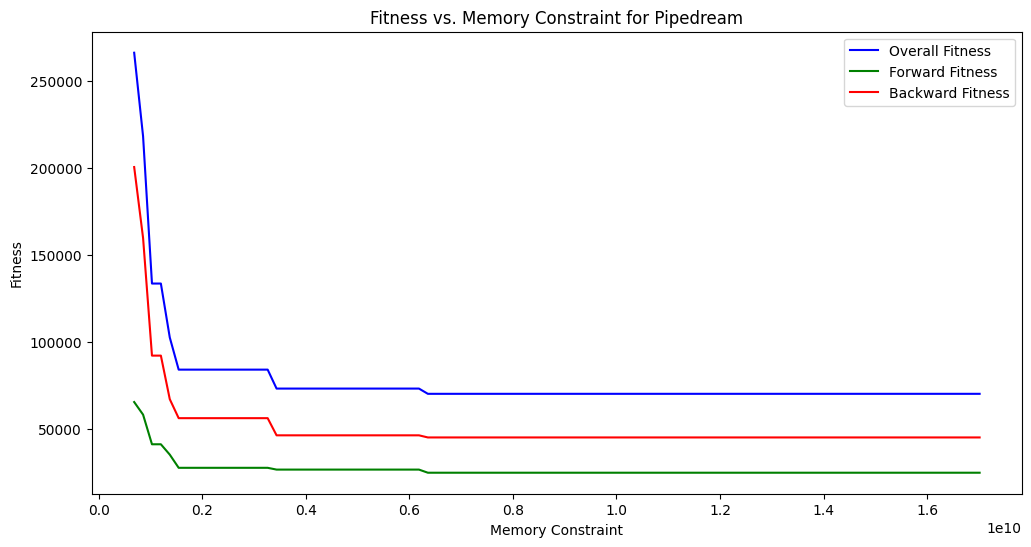

In [5]:
def evaluate_pipeline_configuration(individual, max_memory):
    # Initialize variables for loads and memory usage
    device_load_fw = [0] * (NUM_DEVICES + 1)  # Forward load for each device, +1 to account for the CPU
    device_load_bw = [0] * (NUM_DEVICES + 1)  # Backward load for each device, +1 to account for the CPU
    device_memory_usage = [0] * (NUM_DEVICES + 1)  # Memory usage for each device, +1 to account for the CPU
    communication_time = [0] * (NUM_DEVICES + 1)  # Communication time for each device, +1 to account for the CPU
    energy_costs_forward = [0] * (NUM_DEVICES + 1)  # Energy costs for each device, +1 to account for the CPU
    energy_costs_backward = [0] * (NUM_DEVICES + 1)
    communication_time_fw = [0] * (NUM_DEVICES + 1)  # Forward communication time for each device
    communication_time_bw = [0] * (NUM_DEVICES + 1)  # Backward communication time for each device


    # Process each node in the graph
    for node in graph['nodes']:
        size = node['size']
        weight_memory_cost = node['weightMemory'] * (NUM_DEVICES + 1)
        activation_memory_cost = node['activationMemory']  * (NUM_DEVICES + 1)
        computation_time = node['fpgaLatency'] if node['supportedOnFpga'] else node['cpuLatency']
        node_id = node['id']
        assigned_device = individual[node_id]

        # Update memory usage
        device_memory_usage[assigned_device] += weight_memory_cost + activation_memory_cost

        # Update load based on whether the node is forward or backward
        if not node['isBackwardNode']:
            device_load_fw[assigned_device] += computation_time
            energy_costs_forward[assigned_device] += node['energy']
        else:
            device_load_bw[assigned_device] += computation_time
            energy_costs_backward[assigned_device] += node['energy']

    # Calculate communication time from edges
    for edge in graph['edges']:
      u, v = edge['sourceId'], edge['destId']
      cost = edge['cost']  # Adjust cost for bandwidth

      # Determine devices for the source and destination nodes
      u_device, v_device = individual[u], individual[v]

      # Determine if the nodes are forward or backward
      is_u_forward = not graph['nodes'][u]['isBackwardNode']
      is_v_forward = not graph['nodes'][v]['isBackwardNode']

      # Update load with communication cost if there's a transition between devices
      if u_device != v_device:
          if is_u_forward and is_v_forward:
              # Both nodes are forward
              communication_time_fw[u_device] += cost
              communication_time_fw[v_device] += cost
          elif not is_u_forward and not is_v_forward:
              # Both nodes are backward
              communication_time_bw[u_device] += cost
              communication_time_bw[v_device] += cost
          else:
              # One node is forward and the other is backward, split the cost
              communication_time_fw[u_device] += cost / 2
              communication_time_bw[v_device] += cost / 2
              communication_time_fw[v_device] += cost / 2
              communication_time_bw[u_device] += cost / 2

    max_load_fw = max([device_load_fw[i] + communication_time_fw[i] for i in range(NUM_DEVICES + 1)])
    max_load_bw = max([device_load_bw[i] + communication_time_bw[i] for i in range(NUM_DEVICES + 1)])
    fitness_fw = max_load_fw * max(energy_costs_forward)  # Fitness for forward nodes
    fitness_bw = max_load_bw * max(energy_costs_backward)  # Fitness for backward nodes

    # Check memory constraints
    for i in range(NUM_DEVICES + 1):
        if device_memory_usage[i] > max_memory:
            fitness_fw = float('inf')  # Invalidate if memory exceeded
            fitness_bw = float('inf')
            fitness = float('inf')
            return fitness, fitness_fw, fitness_bw
    fitness = fitness_fw+fitness_bw

    return fitness, fitness_fw, fitness_bw
step_size = maxSizePerFpga//100
memory_constraints = range(int(maxSizePerFpga//100), int(100 * step_size), int(step_size))
edp_results = []
best_overall_individual = None
best_forward = float('inf')
best_backward = float('inf')
best_overall_edp = float('inf')
# Initialize lists to store the best fitness values
best_overall_fitness = []
best_forward_fitness = []
best_backward_fitness = []

for max_memory in memory_constraints:
    toolbox.register("evaluate", evaluate_pipeline_configuration, max_memory=max_memory)
    population = toolbox.population(n=50)
    NGEN = 100
    CXPB = 0.8
    MUTPB = 0.3

    # Evolution
    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit[0],  # Note: fit should be a tuple with 3 values
        population = toolbox.select(offspring, k=len(population))

    best_ind = tools.selBest(population, 1)[0]
    best_fitness = toolbox.evaluate(best_ind)  # Evaluate the best individual
    best_overall_fitness.append(best_overall_edp)
    best_forward_fitness.append(best_forward)
    best_backward_fitness.append(best_backward)

    # Update best overall EDP if necessary
    if best_fitness[0] < best_overall_edp:
        best_overall_individual = best_ind
        best_overall_edp = best_fitness[0]
        best_forward = best_fitness[1]
        best_backward = best_fitness[2]
        print("Best EDP:", best_overall_edp)

if best_overall_individual is not None:
    print("Best EDP:", best_overall_edp)
else:
    print("No feasible solution found within the given memory constraints.")
import matplotlib.pyplot as plt

# Plot for Overall Fitness
plt.figure(figsize=(12, 6))
plt.plot(memory_constraints, best_overall_fitness, label='Overall Fitness', color='blue')
plt.plot(memory_constraints, best_forward_fitness, label='Forward Fitness', color='green')
plt.plot(memory_constraints, best_backward_fitness, label='Backward Fitness', color='red')
plt.xlabel('Memory Constraint')
plt.ylabel('Fitness')
plt.title('Fitness vs. Memory Constraint for Pipedream')
plt.legend()
plt.show()

Best EDP: 175570.66271069812
Best EDP: 112638.58053633064
Best EDP: 81887.37166012969
Best EDP: 78730.59717411545
Best EDP: 78313.98287768784
Best EDP: 77143.0463685932
Best EDP: 76225.48629856051
Best EDP: 74043.69815321654
Best EDP: 74043.69815321654


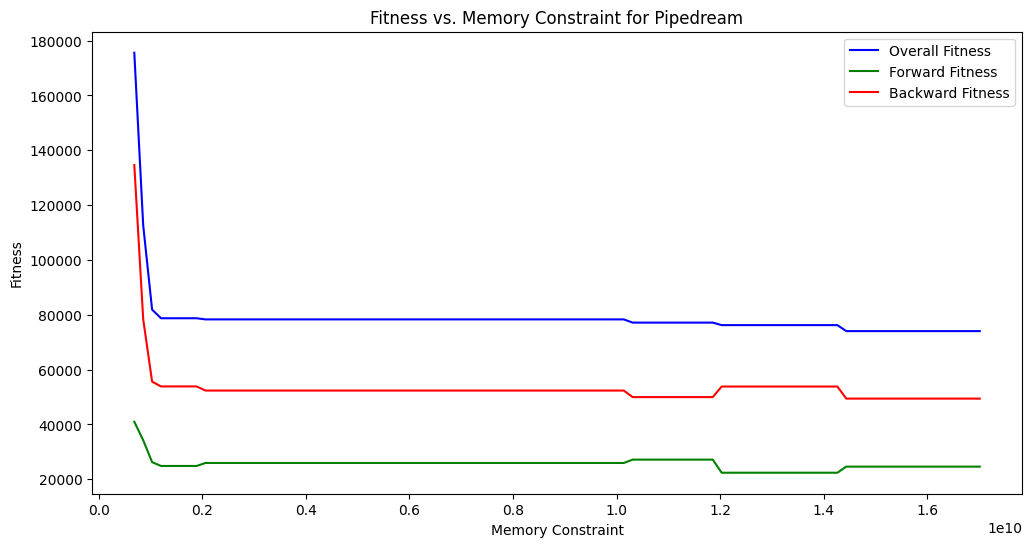

In [6]:
#RUN FOR PIPEDREAM-2BW
def evaluate_pipeline_configuration(individual, max_memory):
    # Initialize variables for loads and memory usage
    device_load_fw = [0] * (NUM_DEVICES + 1)  # Forward load for each device, +1 to account for the CPU
    device_load_bw = [0] * (NUM_DEVICES + 1)  # Backward load for each device, +1 to account for the CPU
    device_memory_usage = [0] * (NUM_DEVICES + 1)  # Memory usage for each device, +1 to account for the CPU
    communication_time = [0] * (NUM_DEVICES + 1)  # Communication time for each device, +1 to account for the CPU
    energy_costs_forward = [0] * (NUM_DEVICES + 1)  # Energy costs for each device, +1 to account for the CPU
    energy_costs_backward = [0] * (NUM_DEVICES + 1)
    communication_time_fw = [0] * (NUM_DEVICES + 1)  # Forward communication time for each device
    communication_time_bw = [0] * (NUM_DEVICES + 1)  # Backward communication time for each device


    # Process each node in the graph
    for node in graph['nodes']:
        size = node['size']
        weight_memory_cost = node['weightMemory'] * 2
        activation_memory_cost = node['activationMemory']  * (NUM_DEVICES + 1)
        computation_time = node['fpgaLatency'] if node['supportedOnFpga'] else node['cpuLatency']
        node_id = node['id']
        assigned_device = individual[node_id]

        # Update memory usage
        device_memory_usage[assigned_device] += weight_memory_cost + activation_memory_cost

        # Update load based on whether the node is forward or backward
        if not node['isBackwardNode']:
            device_load_fw[assigned_device] += computation_time
            energy_costs_forward[assigned_device] += node['energy']
        else:
            device_load_bw[assigned_device] += computation_time
            energy_costs_backward[assigned_device] += node['energy']

    # Calculate communication time from edges
    for edge in graph['edges']:
      u, v = edge['sourceId'], edge['destId']
      cost = edge['cost']  # Adjust cost for bandwidth

      # Determine devices for the source and destination nodes
      u_device, v_device = individual[u], individual[v]

      # Determine if the nodes are forward or backward
      is_u_forward = not graph['nodes'][u]['isBackwardNode']
      is_v_forward = not graph['nodes'][v]['isBackwardNode']

      # Update load with communication cost if there's a transition between devices
      if u_device != v_device:
          if is_u_forward and is_v_forward:
              # Both nodes are forward
              communication_time_fw[u_device] += cost
              communication_time_fw[v_device] += cost
          elif not is_u_forward and not is_v_forward:
              # Both nodes are backward
              communication_time_bw[u_device] += cost
              communication_time_bw[v_device] += cost
          else:
              # One node is forward and the other is backward, split the cost
              communication_time_fw[u_device] += cost / 2
              communication_time_bw[v_device] += cost / 2
              communication_time_fw[v_device] += cost / 2
              communication_time_bw[u_device] += cost / 2

    max_load_fw = max([device_load_fw[i] + communication_time_fw[i] for i in range(NUM_DEVICES + 1)])
    max_load_bw = max([device_load_bw[i] + communication_time_bw[i] for i in range(NUM_DEVICES + 1)])
    fitness_fw = max_load_fw * max(energy_costs_forward)  # Fitness for forward nodes
    fitness_bw = max_load_bw * max(energy_costs_backward)  # Fitness for backward nodes

    # Check memory constraints
    for i in range(NUM_DEVICES + 1):
        if device_memory_usage[i] > max_memory:
            fitness_fw = float('inf')  # Invalidate if memory exceeded
            fitness_bw = float('inf')
            fitness = float('inf')
            return fitness, fitness_fw, fitness_bw
    fitness = fitness_fw+fitness_bw

    return fitness, fitness_fw, fitness_bw
step_size = maxSizePerFpga//100
memory_constraints = range(int(maxSizePerFpga//100), int(100 * step_size), int(step_size))
edp_results = []
best_overall_individual = None
best_forward = float('inf')
best_backward = float('inf')
best_overall_edp = float('inf')
# Initialize lists to store the best fitness values
best_overall_fitness = []
best_forward_fitness = []
best_backward_fitness = []

for max_memory in memory_constraints:
    toolbox.register("evaluate", evaluate_pipeline_configuration, max_memory=max_memory)
    population = toolbox.population(n=50)
    NGEN = 100
    CXPB = 0.8
    MUTPB = 0.3

    # Evolution
    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit[0],  # Note: fit should be a tuple with 3 values
        population = toolbox.select(offspring, k=len(population))

    best_ind = tools.selBest(population, 1)[0]
    best_fitness = toolbox.evaluate(best_ind)  # Evaluate the best individual
    best_overall_fitness.append(best_overall_edp)
    best_forward_fitness.append(best_forward)
    best_backward_fitness.append(best_backward)

    # Update best overall EDP if necessary
    if best_fitness[0] < best_overall_edp:
        best_overall_individual = best_ind
        best_overall_edp = best_fitness[0]
        best_forward = best_fitness[1]
        best_backward = best_fitness[2]
        print("Best EDP:", best_overall_edp)

if best_overall_individual is not None:
    print("Best EDP:", best_overall_edp)
else:
    print("No feasible solution found within the given memory constraints.")
import matplotlib.pyplot as plt

# Plot for Overall Fitness
plt.figure(figsize=(12, 6))
plt.plot(memory_constraints, best_overall_fitness, label='Overall Fitness', color='blue')
plt.plot(memory_constraints, best_forward_fitness, label='Forward Fitness', color='green')
plt.plot(memory_constraints, best_backward_fitness, label='Backward Fitness', color='red')
plt.xlabel('Memory Constraint')
plt.ylabel('Fitness')
plt.title('Fitness vs. Memory Constraint for Pipedream')
plt.legend()
plt.show()